# Ancillary external photometry

This tutorial shows how to use external photometric data to perform astrometry calibrations on a Cube

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import numpy as np

from pykoala.cubing import Cube

cube = Cube(file_path="products/Henize_2-10_cube_no_sky.fits.gz",
            hdul_extensions_map={"INTENSITY": "INTENSITY", "VARIANCE": "VARIANCE"})

# Read the sky position and cube pixel size from the header
he2_10_ra, he2_10_dec = cube.wcs.celestial.wcs.crval[:2]
cube_pix_area = (cube.wcs.celestial.wcs.cdelt[0] * 3600)**2
print(f"Cube position: RA={he2_10_ra}, DEC={he2_10_dec}")
print("Cube pixel area (arcsec^2) ", cube_pix_area)

[Cube] Loading HDUL products/Henize_2-10_cube_no_sky.fits.gz
[Cube] Constructing WCS
[Cube] Updating HDUL INTENSITY
[Cube] Updating HDUL variance
[Cube] Constructing wavelength array
Cube position: RA=129.06270331214, DEC=-26.412717838961
Cube pixel area (arcsec^2)  1.000000000000016


In [12]:
from pykoala.corrections.external_data import AncillaryDataCorrection

anc_data_corr = AncillaryDataCorrection([cube])

# Query r-band photometry from PS using a cutout with the size of the input cube
# + 30 additional arcseconds on every side. Save the fits in the current working directory
anc_data_corr.query_image(survey='PS', filters='r', im_extra_size_arcsec=30, im_output_dir='.')

[Correction: AncillaryData] Querying image to external database
[Correction: AncillaryData] Object footprint:  [array([[129.05680998, -26.42077327],
       [129.05681082, -26.40438438],
       [129.06890594, -26.40438437],
       [129.06890682, -26.42077326]])]
[Correction: AncillaryData] Combined footprint Fov:  0.7258105450495123 0.9833341037292342
[Correction: AncillaryData] Image center sky position (RA, DEC):  (129.06285839986214, -26.412578822823143)
[Correction: AncillaryData] Image size (pixels):  356
Retrieving cutout: ra=129.06285839986214, dec=-26.412578822823143, filter=r
Downloading: https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?size=356&format=fits&ra=129.06285839986214&dec=-26.412578822823143&red=/rings.v3.skycell/0743/031/rings.v3.skycell.0743.031.stk.r.unconv.fits
Saving file at: ./ps_query_129.0629_n26.4126_r.fits
Opening PANSTARRS fits file


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


In [113]:
# Produce synthetic r-band photometry using the cube spectra and measure apertures.
ref_data = anc_data_corr.get_dc_aperture_fluxes(sample_every=2)

Initialising Filter variables
Checking filters available at /home/pcorchoc/Develop/population-synthesis-toolkit/src/pst/data/filters
Filter loaded from: /home/pcorchoc/Develop/population-synthesis-toolkit/src/pst/data/filters/PANSTARRS_PS1.r.dat
Assuming that input wavelength array is in angstrom
Filter transmission curve interpolated to input wavelength array


/home/pcorchoc/Develop/koala/src/pykoala/corrections/external_data.py:441: RuntimeWarning: invalid value encountered in sqrt
  var**0.5 * dc_flux_units)


[Correction: AncillaryData] Computing aperture fluxes using Cube synthetic photometry
[Correction: AncillaryData] Creating a grid of circular aperture (rad=0.62 px) every 2.5 pixels
[Correction: AncillaryData] Total number of apertures: 425


/home/pcorchoc/Develop/koala/src/pykoala/corrections/external_data.py:466: RuntimeWarning: invalid value encountered in log10
  mappable = ax.imshow(-2.5 * np.log10(synth_phot / 3631), vmin=16, vmax=23,
/home/pcorchoc/Develop/koala/src/pykoala/corrections/external_data.py:476: RuntimeWarning: invalid value encountered in log10
  c= -2.5 * np.log10(ap_flux / 3631), vmin=16, vmax=23)


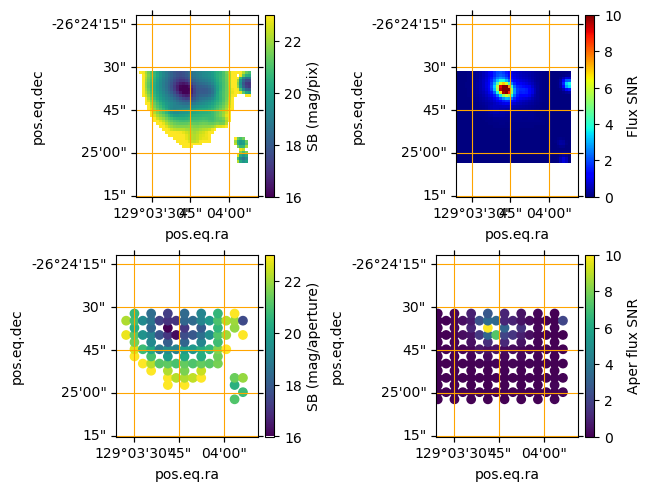

In [114]:
ref_data['PANSTARRS_PS1.r']['figs'][0]

[Correction: AncillaryData] Computing astrometric offsets
Cross-correlating image to list of apertures
Input number of apertures:  152
Computing the offset solution


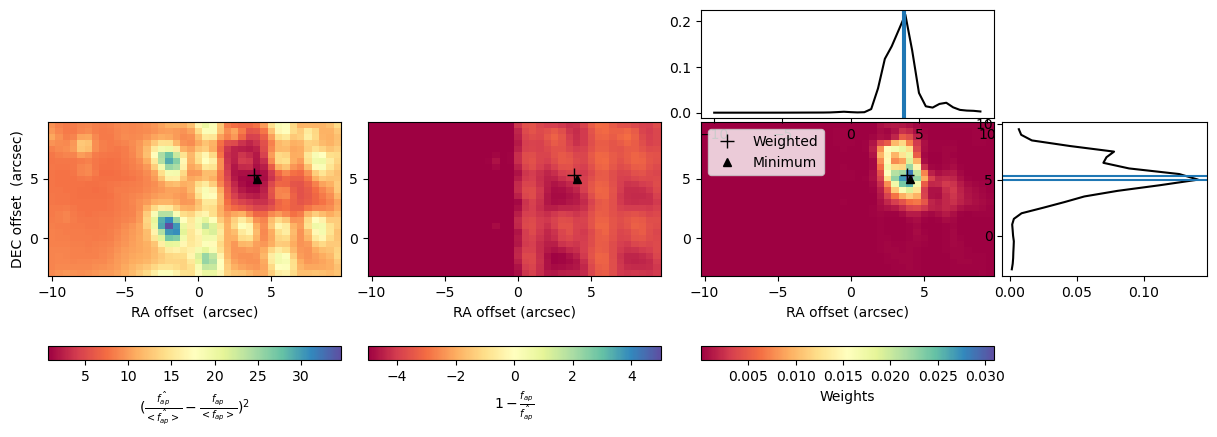

In [119]:
results = anc_data_corr.get_astrometry_offset()

results['offset_fig']

In [5]:
from pykoala.query import getimages, download_image, read_ps_fits
from pykoala.corrections.external_data import PSQuery
from astropy.io import fits
from astropy.wcs import WCS
import numpy as np

tab = PSQuery.getimages([he2_10_ra], [he2_10_dec], size=400)
r_idx = np.where(tab['filter'] == 'r')[0][0]

file = PSQuery.download_image(tab[r_idx]['url'], "ps_cutout.fits")

ps_data, ps_wcs = PSQuery.read_ps_fits(file)



Downloading: https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?size=400&format=fits&ra=129.06270331214&dec=-26.412717838961&red=/rings.v3.skycell/0743/031/rings.v3.skycell.0743.031.stk.r.unconv.fits
Saving file at: ps_cutout.fits
Opening PANSTARRS fits file


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


In [7]:
white_image = cube.get_white_image(wave_range=[6015, 6415], frequency_density=True)
white_image *= 1e-16 * 1e23 # Convert to Fnu in Jy
white_image /= cube_pix_area

white_image_sb = -2.5 * np.log10(white_image / 3631)

/home/pcorchoc/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1872: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pcorchoc/anaconda3/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/home/pcorchoc/Develop/koala/src/pykoala/cubing.py:516: RuntimeWarning: invalid value encountered in divide
  white_image = np.nansum(
/tmp/ipykernel_278463/2492558168.py:5: RuntimeWarning: invalid value encountered in log10
  white_image_sb = -2.5 * np.log10(white_image / 3631)


/tmp/ipykernel_278463/2138642889.py:3: RuntimeWarning: invalid value encountered in log10
  plt.imshow(-2.5 * np.log10(ps_data / 3631), vmin=16, vmax=24, cmap='nipy_spectral')


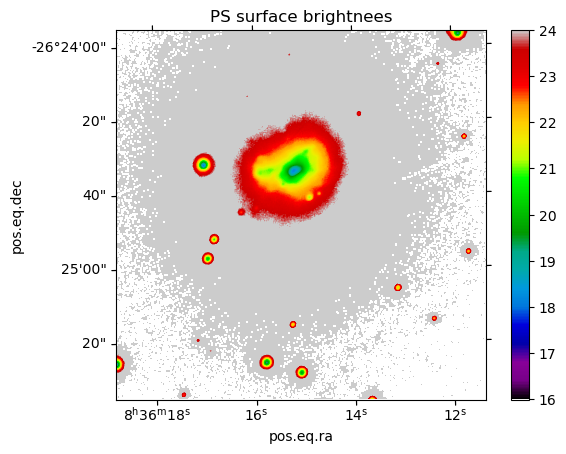

In [8]:
plt.figure()
plt.subplot(111, title='PS surface brightnees', projection=ps_wcs)
plt.imshow(-2.5 * np.log10(ps_data / 3631), vmin=16, vmax=24, cmap='nipy_spectral')
plt.colorbar()



In [9]:
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy import units as u

cube_cutout = Cutout2D(ps_data,
                       position=SkyCoord([129.0627], [-26.412717], unit='deg'),
                       size=(60 * 0.00027777777777778 * u.deg, 50 * 0.00027777777777778 * u.deg),
                       wcs=ps_wcs)


/tmp/ipykernel_278463/1612313376.py:7: RuntimeWarning: invalid value encountered in log10
  mappable = ax.imshow(-2.5 * np.log10(cube_cutout.data / 3631 / 0.25**2), **im_args)
/tmp/ipykernel_278463/1612313376.py:11: RuntimeWarning: invalid value encountered in log10
  ax.contour(np.log10(white_image), transform=ax.get_transform(cube.wcs.celestial),
/tmp/ipykernel_278463/1612313376.py:15: RuntimeWarning: invalid value encountered in log10
  mappable = ax.imshow(-2.5 * np.log10(s / 3631), **im_args)


(39.5, -0.5)

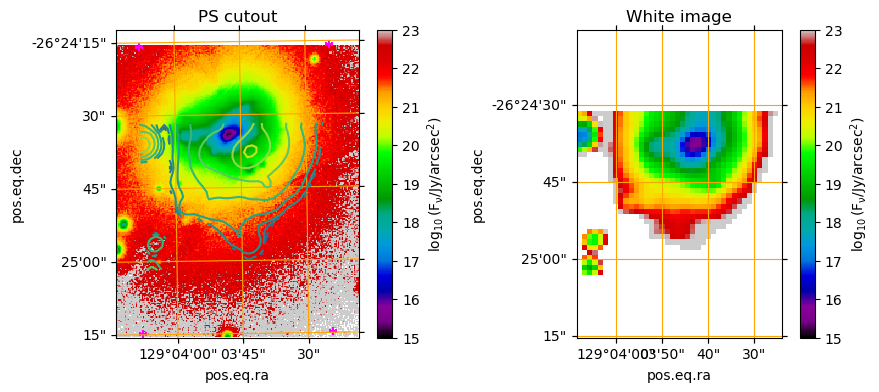

In [36]:
im_args = dict(interpolation='none', cmap='nipy_spectral', vmin=15, vmax=23)

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121, title='PS cutout', projection=cube_cutout.wcs)
ax.coords.grid(True, color='orange', ls='solid')
ax.coords[0].set_format_unit('deg')
mappable = ax.imshow(-2.5 * np.log10(cube_cutout.data / 3631 / 0.25**2), **im_args)
ax.scatter(cube_footprint[:, 0], cube_footprint[:, 1],
           c='fuchsia', marker='+', transform=ax.get_transform('world'))
plt.colorbar(mappable, ax=ax, label=r"$\rm \log_{10}(F_\nu / Jy / arcsec^2)$")
ax.contour(np.log10(white_image), transform=ax.get_transform(cube.wcs.celestial),
           levels=10)

ax = fig.add_subplot(122, title='White image', projection=cube.wcs.celestial)
mappable = ax.imshow(-2.5 * np.log10(s / 3631), **im_args)
ax.coords.grid(True, color='orange', ls='solid')
ax.coords[0].set_format_unit('deg')
plt.colorbar(mappable, ax=ax, label=r"$\rm \log_{10}(F_\nu / Jy / arcsec^2)$")
x_lim = ax.get_xlim()
ax.set_xlim(x_lim[1], x_lim[0])


/tmp/ipykernel_278463/720863835.py:17: RuntimeWarning: invalid value encountered in log10
  mappable = ax.imshow(np.log10(white_image), **im_args)


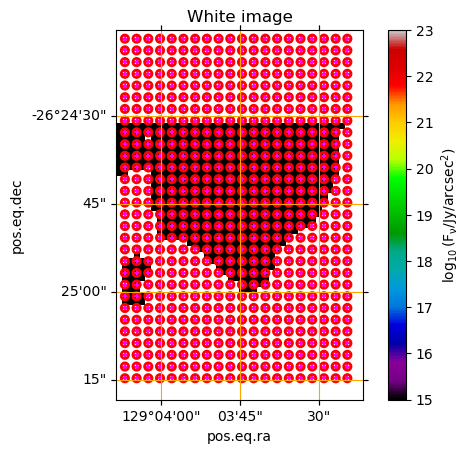

In [46]:
# Photometry

from photutils.aperture import SkyCircularAperture, aperture_photometry, ApertureStats
from astropy import units as u

rows = np.arange(0, white_image.shape[0], 2)
columns = np.arange(0, white_image.shape[1], 2)

yy, xx = np.meshgrid(rows, columns)

coordinates = cube.wcs.celestial.pixel_to_world(xx.flatten(), yy.flatten())

apertures = SkyCircularAperture(coordinates, r=1.25 / 2 * u.arcsec)

fig = plt.figure()
ax = fig.add_subplot(111, title='White image', projection=cube.wcs.celestial)
mappable = ax.imshow(np.log10(white_image), **im_args)
ax.scatter(coordinates.ra, coordinates.dec,
           c='fuchsia', marker='+', fc='none', ec='fuchsia', transform=ax.get_transform('world'))
pix_aperture = apertures.to_pixel(cube.wcs.celestial)
ap_patches = pix_aperture.plot(color='red', lw=2,
                           label='Photometry aperture')
ax.coords.grid(True, color='orange', ls='solid')
ax.coords[0].set_format_unit('deg')
plt.colorbar(mappable, ax=ax, label=r"$\rm \log_{10}(F_\nu / Jy / arcsec^2)$")
x_lim = ax.get_xlim()
ax.set_xlim(x_lim[1], x_lim[0])


# Create the reference set of apertures

reference_table = ApertureStats(white_image * cube_pix_area,
apertures, wcs=cube.wcs.celestial, sum_method='exact')


In [ ]:
from pykoala.corrections.external_data import crosscorrelate_im_apertures

flux_in_ap = reference_table.mean * np.sqrt(reference_table.center_aper_area.value)

results = crosscorrelate_im_apertures(flux_in_ap, coordinates, cube_cutout.data, cube_cutout.wcs)
print(results)


Min offset:  4.5 4.5 
Mean weighted offset:  2.8363193883285174 2.736449550110358


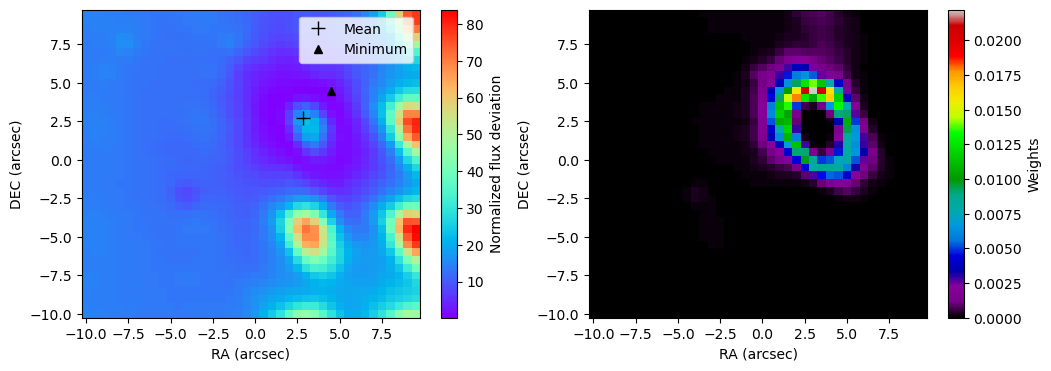

In [65]:
ra_mean, dec_mean = results['offset_mean']

ra_min, dec_min = results['offset_min']

print("Min offset: ", ra_min, dec_min,
      "\nMean weighted offset: ", ra_mean, dec_mean)

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.pcolormesh(results['ra_offset'], results['dec_offset'], results['results'][0], cmap='rainbow')
plt.plot(ra_mean, dec_mean, 'k+', ms=10, label='Mean')
plt.plot(ra_min, dec_min, 'k^', label='Minimum')
plt.legend()
plt.xlabel("RA (arcsec)")
plt.ylabel("DEC (arcsec)")
plt.colorbar(label='Normalized flux deviation')
plt.subplot(122)
plt.pcolormesh(results['ra_offset'], results['dec_offset'], results['weights'], cmap='nipy_spectral')
plt.xlabel("RA (arcsec)")
plt.ylabel("DEC (arcsec)")
plt.colorbar(label='Weights')

In [ ]:
new_coords = SkyCoord(
        coordinates.ra + ra_min * u.arcsec,
        coordinates.dec + dec_min * u.arcsec)
new_apertures = SkyCircularAperture(new_coords, r=1.25 / 2 * u.arcsec)

table = ApertureStats(ps_data, new_apertures, wcs=ps_wcs,
sum_method='exact')

ps_flux_in_ap = table.mean * np.sqrt(table.center_aper_area.value)
ps_flux_in_ap_norm = np.nanmean(ps_flux_in_ap)

fig = plt.figure(figsize=(9, 3))
ax = fig.add_subplot(131, title='Reference', projection=cube.wcs.celestial)
ax.scatter(coordinates.ra, coordinates.dec,
        marker='o', transform=ax.get_transform('world'),
        c=np.log10(flux_in_ap),
        vmin=im_args['vmin'], vmax=im_args['vmax'],
        cmap='nipy_spectral')
ax.coords.grid(True, color='orange', ls='solid')
ax.coords[0].set_format_unit('deg')

ax = fig.add_subplot(132, title='PS', projection=cube.wcs.celestial)
ax.scatter(coordinates.ra, coordinates.dec,
        marker='o', transform=ax.get_transform('world'),
        c=np.log10(ps_flux_in_ap),
        vmin=im_args['vmin'], vmax=im_args['vmax'],
        cmap='nipy_spectral')

ax.coords.grid(True, color='orange', ls='solid')
ax.coords[0].set_format_unit('deg')


ax = fig.add_subplot(133, title='Ref / PS', projection=cube.wcs.celestial)
mappable = ax.scatter(coordinates.ra, coordinates.dec,
        marker='o', transform=ax.get_transform('world'),
        c= flux_in_ap / ps_flux_in_ap,
        vmin=0, vmax=2,
        cmap='nipy_spectral')

ax.coords.grid(True, color='orange', ls='solid')
ax.coords[0].set_format_unit('deg')
plt.colorbar(mappable, ax=ax)




In [ ]:
cube.wcs

In [ ]:
# Update the cube WCS
cube.wcs.wcs.crval[0] = cube.wcs.wcs.crval[0] + ra_min / 3600
cube.wcs.wcs.crval[1] = cube.wcs.wcs.crval[1] + dec_min / 3600
cube.wcs

In [ ]:
im_args = dict(interpolation='none', cmap='nipy_spectral', vmin=-5, vmax=-2)

fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(121, title='PS cutout', projection=cube_cutout.wcs)
ax.coords.grid(True, color='orange', ls='solid')
ax.coords[0].set_format_unit('deg')
mappable = ax.imshow(np.log10(cube_cutout.data), **im_args)
ax.scatter(cube_footprint[:, 0], cube_footprint[:, 1],
           c='fuchsia', marker='+', transform=ax.get_transform('world'))
plt.colorbar(mappable, ax=ax, label=r"$\rm \log_{10}(F_\nu / Jy / arcsec^2)$")
ax.contour(np.log10(white_image), transform=ax.get_transform(cube.wcs.celestial),
           levels=10)

ax = fig.add_subplot(122, title='White image', projection=cube.wcs.celestial)
mappable = ax.imshow(np.log10(white_image), **im_args)
ax.coords.grid(True, color='orange', ls='solid')
ax.coords[0].set_format_unit('deg')
plt.colorbar(mappable, ax=ax, label=r"$\rm \log_{10}(F_\nu / Jy / arcsec^2)$")
x_lim = ax.get_xlim()
ax.set_xlim(x_lim[1], x_lim[0])
